In [45]:
import pandas as pd
import numpy as np
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

import tiktoken

import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt

from gensim.parsing.preprocessing import remove_stopwords
from gensim.parsing.porter import PorterStemmer
from nltk.tokenize import RegexpTokenizer
from gensim import corpora, models, similarities
from smart_open import smart_open

In [46]:
df = pd.read_csv("recursive_data/total/total_cleaned.csv")
osi = pd.read_csv("osi.csv")

df = pd.concat([df,osi],ignore_index=True)
df = df.drop_duplicates(subset=["url"])

In [47]:
df.url.value_counts(ascending=False
                )

url
https://www.cftc.gov/idc/groups/public/documents/file/pt40cs-doc.docx                                         1
https://www.cftc.gov/sites/default/files/2018-11/11%20-%20FCM%20Webpage%20Update%20-%20November%202018.pdf    1
https://www.cftc.gov/sites/default/files/2022-01/01-%20FCM%20Webpage%20Update%20-%20November%202021.pdf       1
https://www.cftc.gov/sites/default/files/2023/01/01%20-%20FCM%20Webpage%20Update%20-%20November%202022.pdf    1
https://www.cftc.gov/sites/default/files/2024-01/01%20-%20FCM%20Webpage%20Update%20-%20November%202023.pdf    1
                                                                                                             ..
https://www.esma.europa.eu/sites/default/files/library/IT%20DoI%20Stecconi.pdf                                1
https://www.esma.europa.eu/sites/default/files/it_doi_frettoni.pdf                                            1
https://www.esma.europa.eu/sites/default/files/it_doi_comporti.pdf                                  

In [48]:
df.shape

(2647, 3)

## Basic view of the csv

In [49]:
df["source"].value_counts()

source
ESMA         1011
FED           472
FINRA         403
CFTC          227
OSI           165
NYSE          133
EUR-LEX        76
XBRL_WEB       71
CDM            71
SBOA           11
SEC_RULES       2
III             1
FDIC            1
FINOS           1
XBRL_DOC        1
SEC             1
Name: count, dtype: int64

In [50]:
df[df["source"]=="SEC_RULES"]

url     source  \
2439  https://www.sec.gov/rules-regulations  SEC_RULES   
2442          https://www.sec.gov/developer  SEC_RULES   

                                                content  
2439  U.S. Securities and Exchange Commission\nAutom...  
2442  U.S. Securities and Exchange Commission\nAutom...

In [34]:
encoding = tiktoken.encoding_for_model("gpt-4o-mini")

def num_tokens_from_string(string, encoding) -> int:
    """Returns the number of tokens in a text string."""
    num_tokens = len(encoding.encode(string))
    return num_tokens


df = df.assign(num_tokens = df["content"].apply(lambda x: num_tokens_from_string(x, encoding)))

In [36]:
df["num_tokens"]

0          1
1       3330
2       1587
3       4938
4       4873
        ... 
2802    2218
2803     787
2804    1006
2816     599
2817     840
Name: num_tokens, Length: 2647, dtype: int64

In [35]:
df.num_tokens.describe()

count    2.647000e+03
mean     1.216226e+04
std      4.722663e+04
min      1.000000e+00
25%      9.065000e+02
50%      2.396000e+03
75%      1.140750e+04
max      1.387701e+06
Name: num_tokens, dtype: float64

In [95]:
print(df[df["num_tokens"] == df.num_tokens.max()].url.iloc[0])

https://www.federalreserve.gov/publications/files/bhc.pdf


<Axes: xlabel='num_tokens', ylabel='Count'>

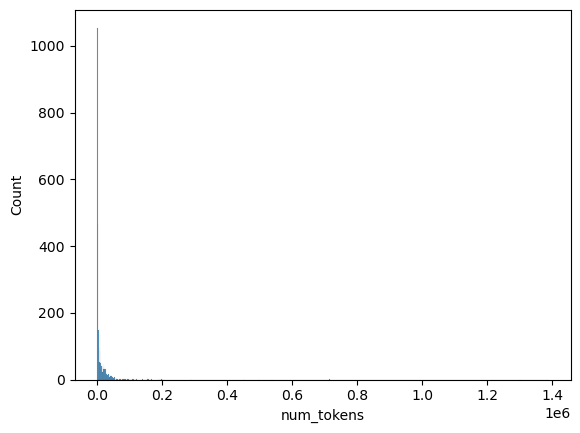

In [96]:
sns.histplot(data=df, x="num_tokens")


## Corpus Modeling

In [97]:
p = PorterStemmer()
tokenizer = RegexpTokenizer(r'\w+')
# Función de preprocesamiento, se usará para todos los inputs al modelo (queries y documentos)
def preprocess_text(text: str):
    """Preprocesa un texto para eliminar palabras vacías, aplicar stemming y convertir a minúsculas.

    Args:
        text (str): El texto a preprocesar.

    Returns:
        List: Una lista con las palabras del texto preprocesado.
    """
    text = text.strip().lower()  # Normalización del texto, todo en minúscula y se quitan espacios innecesarios.
    doc_sw = remove_stopwords(text)
    doc_stem = p.stem_sentence(doc_sw)
    return tokenizer.tokenize(doc_stem) # Retorna lista con el texto preprocesado

In [98]:
df = df.assign(preproc_text = df["content"].apply(lambda x: preprocess_text(x)))

In [99]:
corpus = df.preproc_text.to_list()

In [100]:
len(corpus)

2761

In [101]:
composite_terms = [
    "market abuse", "payment system", "anti money laundering", "know your customer",
    "capital requirement", "financial service", "banking law", "securities regulation",
    "corporate governance", "fiduciary duty", "disclosure requirements", "risk management",
    "financial stability", "consumer protection", "data protection", "financial crime",
    "fraud prevention", "insider trading", "conflict of interest", "reporting obligation",
    "whistleblower protection", "ethical standards", "financial oversight", "investment guideline",
    "tax law", "fiscal policy", "monetary policy", "currency regulation", "exchange control",
    "credit regulation", "insurance regulation", "pension regulation", "financial instrument",
    "financial market infrastructure", "clearing and settlement", "digital currency",
    "blockchain", "cryptocurrency", "initial coin offering", "electronic money", "payment service",
    "crowdfunding", "peer to peer lending", "robo advisory", "virtual asset", "financial innovation", "open source", "free license", "limited license", "open license"
    "open source", "permissive license", "dual licensing", "source code", "binary form", "derivative work"
]

# Function to replace spaces in composite terms with underscores
def preprocess_composite_terms(text, composite_terms):
    for term in composite_terms:
        new_text = text.replace(term, term.replace(" ", ""))
        if text!=new_text:
            text = new_text

    return text


In [102]:
# Path to the new file
corpus_file_path = "mycorpusGensim.txt"
text_corpus_en = []
with open(corpus_file_path, 'w', encoding='utf-8') as corpus_file:
    # Iterate over XML files in the directory
    for row in df.iterrows():
        guard = False
        content = row[1].content
        content = preprocess_composite_terms(content, composite_terms)
        content_without_newlines = content.replace('\n', '')
        encoded_content = content_without_newlines.encode('utf-8', errors='ignore').decode('utf-8')
        corpus_file.write(encoded_content + '\n')
        # Preprocess the content
        preprocessed_tokens = preprocess_text(content)
        text_corpus_en.append(preprocessed_tokens)

print("Corpus created.")

Corpus created.


In [103]:
dictionary = corpora.Dictionary(text_corpus_en)
dictionary.save("midict.dict")
print(dictionary)

2024-10-29 18:36:39,180 : INFO : adding document #0 to Dictionary<0 unique tokens: []>
2024-10-29 18:36:46,050 : INFO : built Dictionary<341592 unique tokens: ['2', '2025', '22', '24', '24165']...> from 2761 documents (total 13469750 corpus positions)
2024-10-29 18:36:46,050 : INFO : Dictionary lifecycle event {'msg': "built Dictionary<341592 unique tokens: ['2', '2025', '22', '24', '24165']...> from 2761 documents (total 13469750 corpus positions)", 'datetime': '2024-10-29T18:36:46.050948', 'gensim': '4.3.3', 'python': '3.10.15 | packaged by Anaconda, Inc. | (main, Oct  3 2024, 07:22:19) [MSC v.1929 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.22631-SP0', 'event': 'created'}
2024-10-29 18:36:46,318 : INFO : Dictionary lifecycle event {'fname_or_handle': 'midict.dict', 'separately': 'None', 'sep_limit': 10485760, 'ignore': frozenset(), 'datetime': '2024-10-29T18:36:46.318271', 'gensim': '4.3.3', 'python': '3.10.15 | packaged by Anaconda, Inc. | (main, Oct  3 2024, 07:22:19) [MSC v.19

Dictionary<341592 unique tokens: ['2', '2025', '22', '24', '24165']...>


In [104]:
##  Market Matrix format
# Step 1: Build the corpus from big file
class MyCorpus(object):
    def __iter__(self):
        for line in smart_open("mycorpusGensim.txt","rb"):
            yield dictionary.doc2bow(preprocess_text(line))

corpus_memory_friendly = MyCorpus()
corpora.MmCorpus.serialize("corpus.mm", corpus_memory_friendly)
corpus = corpora.MmCorpus("corpus.mm")

2024-10-29 18:36:46,466 : INFO : storing corpus in Matrix Market format to corpus.mm
2024-10-29 18:36:46,466 : INFO : saving sparse matrix to corpus.mm
2024-10-29 18:36:46,483 : INFO : PROGRESS: saving document #0
2024-10-29 18:37:35,578 : INFO : PROGRESS: saving document #1000
2024-10-29 18:38:17,722 : INFO : PROGRESS: saving document #2000
2024-10-29 18:38:24,704 : INFO : saved 2761x341592 matrix, density=0.257% (2424541/943135512)
2024-10-29 18:38:24,704 : INFO : saving MmCorpus index to corpus.mm.index
2024-10-29 18:38:24,719 : INFO : loaded corpus index from corpus.mm.index
2024-10-29 18:38:24,719 : INFO : initializing cython corpus reader from corpus.mm
2024-10-29 18:38:24,735 : INFO : accepted corpus with 2761 documents, 341592 features, 2424541 non-zero entries


In [105]:
# Step 2: Build Tfidf model from corpus
dictionary = corpora.Dictionary.load('midict.dict')
corpus = corpora.MmCorpus("corpus.mm")
tfidf = models.TfidfModel(corpus)

# You can transform any doc using your model
query = "Regulation, law, statute" 
query_doc_bow = dictionary.doc2bow(preprocess_text(query)) # Important: Same corpus preprocess
print(query_doc_bow)
print(tfidf[query_doc_bow]) # Model transformation

2024-10-29 18:38:24,758 : INFO : loading Dictionary object from midict.dict
2024-10-29 18:38:24,928 : INFO : Dictionary lifecycle event {'fname': 'midict.dict', 'datetime': '2024-10-29T18:38:24.928165', 'gensim': '4.3.3', 'python': '3.10.15 | packaged by Anaconda, Inc. | (main, Oct  3 2024, 07:22:19) [MSC v.1929 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.22631-SP0', 'event': 'loaded'}
2024-10-29 18:38:24,943 : INFO : loaded corpus index from corpus.mm.index
2024-10-29 18:38:24,943 : INFO : initializing cython corpus reader from corpus.mm
2024-10-29 18:38:24,943 : INFO : accepted corpus with 2761 documents, 341592 features, 2424541 non-zero entries
2024-10-29 18:38:24,943 : INFO : collecting document frequencies
2024-10-29 18:38:24,943 : INFO : PROGRESS: processing document #0
2024-10-29 18:38:28,187 : INFO : TfidfModel lifecycle event {'msg': 'calculated IDF weights for 2761 documents and 341592 features (2424541 matrix non-zeros)', 'datetime': '2024-10-29T18:38:28.187958', 'gensim

[(3024, 1), (3697, 1), (22130, 1)]
[(3024, 0.2596633285191776), (3697, 0.35708984732378407), (22130, 0.8972523595737257)]


In [106]:
# Step 3: Similarity Matrix
# In this step the index is created
index = similarities.MatrixSimilarity(tfidf[corpus])
index.save('similmatrix.index')

2024-10-29 18:38:28,312 : WARNING : scanning corpus to determine the number of features (consider setting `num_features` explicitly)
2024-10-29 18:38:33,806 : INFO : creating matrix with 2761 documents and 341592 features
2024-10-29 18:38:52,138 : INFO : MatrixSimilarity lifecycle event {'fname_or_handle': 'similmatrix.index', 'separately': 'None', 'sep_limit': 10485760, 'ignore': frozenset(), 'datetime': '2024-10-29T18:38:52.138541', 'gensim': '4.3.3', 'python': '3.10.15 | packaged by Anaconda, Inc. | (main, Oct  3 2024, 07:22:19) [MSC v.1929 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.22631-SP0', 'event': 'saving'}
2024-10-29 18:38:52,138 : INFO : storing np array 'index' to similmatrix.index.index.npy
2024-10-29 18:39:01,899 : INFO : saved similmatrix.index


In [107]:
pos_query = """Regulation, law, statute, council, commission, article, compliance, directive, guideline, standard,
legislation, regulatory framework, policy, decree, act, provision, rule, amendment, enforcement, 
supervisory authority, financial conduct, oversight, legal framework, code of practice, 
prudential regulation, anti-money laundering (AML), know your customer (KYC), 
sanction, financial service, banking law, securities regulation, corporate governance, 
fiduciary duty, disclosure requirements, risk management, audit, inspection, 
financial stability, consumer protection, data protection, privacy, cybersecurity, 
financial crime, fraud prevention, capital requirement, solvency, liquidity, 
market abuse, insider trading, conflict of interest, transparency, reporting obligation, 
whistleblower protection, ethical standards, financial oversight, investment guideline, 
tax law, fiscal policy, monetary policy, currency regulation, exchange control, 
credit regulation, insurance regulation, pension regulation, derivative, 
financial instrument, payment system, financial market infrastructure, 
clearing, settlement, fintech, digital currency, blockchain, cryptocurrency, 
initial coin offering (ICO), electronic money, payment service, crowdfunding, 
peer-to-peer lending, robo-advisory, virtual asset, financial innovation, open source, Permissive License, Dual Licensing, Source Code, Binary Form, Distribution, Contribution,
derivative work, attribution, Patent Grant, warranty, liability, trademark"""


neg_query = """"cookies", "submenu", "toggle", "contact", "help", "home", "about", "navigation", "footer", "header", "sidebar", "dropdown", 
"sitemap", "login", "register", "user interface", "UI", "UX", "user experience", "breadcrumbs", "carousel", "slider", 
"accordion", "tab", "widget", "modal", "popup", "overlay", "hamburger menu", "footer menu", "social media links", 
"privacy policy", "terms of use", "disclaimer", "search bar", 
"login form", "sign up", "account settings", "profile", "logout", "dashboard", "settings", "preferences", 
"site map", "accessibility", "mobile menu", "responsive design", "click here", "more info", "gallery",
"webmaster", "copyright", "legal notice", "back to top", "scroll to", "navigation bar", "menu item", 
"site navigation", "page layout", "layout", "theme", "template", "CSS", "HTML", "JavaScript", "web development", 
"web design", "frontend", "backend", "server-side", "client-side", "framework", "library", "API", "REST", "SOAP", "web service", "HTTP", "HTTPS", "SSL", "secure connection", "domain name", "URL", "URI", "web hosting", "cloud hosting", 
"server", "database", "SQL", "NoSQL", "CMS", "content management system", "WordPress", "Joomla", "Drupal", "Magento", 
"Shopify", "Wix", "Squarespace", "web page", "landing page", "homepage", "blog", "post", "comment section", "linkedin", "flickr", "facebook", "instagram", "threads", "x", "twitter"""


# query_doc_bow = dictionary.doc2bow(preprocess_text(query))
# sims = index[tfidf[query_doc_bow]]
# print(list(enumerate(sims)))

# # Sort the vector based on the second value in each tuple
# vector= list(enumerate(sims))
# sorted_vector = sorted(vector, key=lambda x: x[1], reverse=True)

# # Print the sorted vector
# for index, value in sorted_vector:
#     print(f"Index: {index+1}, Value: {value}")

In [108]:
# Function to retrieve and rank documents based on cosine similarity scores
def retrieve_and_rank_documents(pos_query, neg_query):
    # Initialize the similarity index
    index = similarities.MatrixSimilarity(tfidf[corpus])
    
    # Convert the positive and negative queries into bag-of-words format
    query_pos_doc_bow = dictionary.doc2bow(preprocess_text(pos_query))
    query_neg_doc_bow = dictionary.doc2bow(preprocess_text(neg_query))
    
    # Compute cosine similarity scores for both queries
    sims_pos = index[tfidf[query_pos_doc_bow]]
    sims_neg = index[tfidf[query_neg_doc_bow]]
    
    # Combine positive and negative scores to compute a final score for each document
    # Here, we subtract the negative score from the positive score to penalize documents
    # that are more relevant to the negative query.
    final_scores = [(index, pos_score - neg_score) for index, (pos_score, neg_score) in enumerate(zip(sims_pos, sims_neg))]
    
    # Sort the documents based on the final score in descending order
    sorted_scores = sorted(final_scores, key=lambda x: x[1], reverse=True)
    
    return sorted_scores

ranking = retrieve_and_rank_documents(pos_query, neg_query)

2024-10-29 18:39:01,963 : WARNING : scanning corpus to determine the number of features (consider setting `num_features` explicitly)
2024-10-29 18:39:07,562 : INFO : creating matrix with 2761 documents and 341592 features


In [109]:
ranking

[(346, 0.16243672),
 (1857, 0.12268034),
 (383, 0.12113094),
 (127, 0.102223165),
 (2137, 0.09977641),
 (453, 0.09652719),
 (2659, 0.091699034),
 (2662, 0.0878333),
 (2691, 0.08466446),
 (2709, 0.08466446),
 (2710, 0.07953447),
 (1630, 0.07884412),
 (2639, 0.07740056),
 (1849, 0.07714754),
 (2644, 0.07689758),
 (2640, 0.07673764),
 (2642, 0.07589828),
 (446, 0.07398609),
 (1953, 0.07286845),
 (494, 0.07189804),
 (1836, 0.07106271),
 (204, 0.06980118),
 (2712, 0.0696687),
 (2730, 0.0696687),
 (2359, 0.069586724),
 (2094, 0.06896837),
 (2664, 0.06826198),
 (2714, 0.06800293),
 (2738, 0.06800293),
 (490, 0.067471415),
 (429, 0.06709318),
 (2566, 0.0667236),
 (941, 0.06620915),
 (2119, 0.065869376),
 (2109, 0.065408856),
 (2184, 0.064224124),
 (355, 0.06418159),
 (1850, 0.062122513),
 (2734, 0.061323803),
 (2753, 0.061323803),
 (186, 0.060879823),
 (1248, 0.05998557),
 (942, 0.05980356),
 (198, 0.05973942),
 (191, 0.059234865),
 (197, 0.05806584),
 (151, 0.058024116),
 (2573, 0.057934158),

In [110]:
df.head()

url source  \
0  https://www.cftc.gov/idc/groups/public/documen...   CFTC   
1  https://www.esma.europa.eu/sites/default/files...   ESMA   
2  https://www.esma.europa.eu/sites/default/files...   ESMA   
3  https://www.esma.europa.eu/sites/default/files...   ESMA   
4  https://www.esma.europa.eu/sites/default/files...   ESMA   

                                             content  num_tokens  \
0                                                 \n           1   
1  \n\n\nReply form\nReview of RTS 22 on transact...        3330   
2  \n\n\nReply form\non the Consultation Paper 3\...        1587   
3  \n\n\nReply form: MiFIR Review\nRTS 2, RTS on ...        4938   
4  \n\n\nReply form: MiFIR Review\nTechnical Stan...        4873   

                                        preproc_text  
0                                                 []  
1  [repli, form, review, rt, 22, transact, data, ...  
2  [repli, form, consult, paper, 3, respond, pape...  
3  [repli, form, mifir, review, rt, 2, rt, reason...  
4  [repli, form, mifir, review, technic, standard...

In [111]:
# cookies, submenu, toggle, contact, help, home, about
# hyphenate certain words for negative query: social-media, 
print(df.iloc[259].content)

 
1  
  Having regard to Article 43(2) of Regulation (EU) No 600/2014 of the European Parliament and of the Council of 15 May 2014 on markets in financial instr uments and amending Regulation (EU) No 648/2012 (
1), Having regard to Article 44(1) of Regulation (EU) No 1095/2010 of the European Parliament and of the Council of 24 November 2010 establishing a European Supervisory Authority (European Securities and Markets Authority), amending Decision No 716/2009/EC and repealing Commission Decision 2009/77/EC (
2),  THE EUROPEAN SECURITIES AND MARKETS AUTHORITY BOARD OF SUPERVISORS HAS ADOPTED THIS OPINION: 1. Introduction and legal basis (1) National competent authorities (NCAs) may take product inte rvention measures in accordance with Article 42 of Regulation (EU) No 600/2014. At l east one month before a measure is intended to take effect, an NCA must notify all othe r NCAs and the European Securities and Markets Authority (ESMA) of the details of its p roposed measure and the relate

## Filtering and Further Analysis

In [112]:
# Convert ranking to DataFrame
ranking_df = pd.DataFrame(ranking, columns=['index', 'score'])

# Merge ranking scores into your main DataFrame
df['index'] = df.index
df = pd.merge(df, ranking_df, on='index', how='left')

In [113]:
df.head()

url source  \
0  https://www.cftc.gov/idc/groups/public/documen...   CFTC   
1  https://www.esma.europa.eu/sites/default/files...   ESMA   
2  https://www.esma.europa.eu/sites/default/files...   ESMA   
3  https://www.esma.europa.eu/sites/default/files...   ESMA   
4  https://www.esma.europa.eu/sites/default/files...   ESMA   

                                             content  num_tokens  \
0                                                 \n           1   
1  \n\n\nReply form\nReview of RTS 22 on transact...        3330   
2  \n\n\nReply form\non the Consultation Paper 3\...        1587   
3  \n\n\nReply form: MiFIR Review\nRTS 2, RTS on ...        4938   
4  \n\n\nReply form: MiFIR Review\nTechnical Stan...        4873   

                                        preproc_text  index     score  
0                                                 []      0  0.000000  
1  [repli, form, review, rt, 22, transact, data, ...      1 -0.014852  
2  [repli, form, consult, paper, 3, respond, pape...      2 -0.016438  
3  [repli, form, mifir, review, rt, 2, rt, reason...      3 -0.020061  
4  [repli, form, mifir, review, technic, standard...      4 -0.015256

Assuming 20% of noise

In [114]:
good_per = 0.80
# Sort by score in ascending order
df_sorted = df.sort_values(by='score', ascending=True)

# Calculate the threshold for the bottom 66% (to filter the top 33%)
threshold = int(len(df_sorted) * good_per)

# Filter bottom 66% documents (as df_filtered)
df_filtered = df_sorted.tail(threshold)

# Filter top 33% documents (as df_noisy)
df_noisy = df_sorted.head(len(df_sorted) - threshold)

# df_filtered will contain the bottom 66% documents
# df_noisy will contain the top 33% documents


In [115]:
df_sorted.iloc[threshold]["score"]

0.023371259

In [116]:
len(df_sorted)

2761

In [117]:
len(df_filtered)

2208

In [118]:
len(df_sorted)-len(df_filtered)

553

In [119]:
df_filtered.head()

url source  \
1469              https://www.ice.com/products/34361119   NYSE   
1468              https://www.ice.com/products/34361119   NYSE   
1467              https://www.ice.com/products/34361119   NYSE   
2195  https://www.federalreserve.gov/monetarypolicy/...    FED   
2129  https://www.cftc.gov/About/EconomicAnalysis/in...   CFTC   

                                                content  num_tokens  \
1469  ICE\nNYSE\n|\nLOGIN\nWEBICE\nICE Logo\nSolutio...        1665   
1468  ICE\nNYSE\n|\nLOGIN\nWEBICE\nICE Logo\nSolutio...        1668   
1467  ICE\nNYSE\n|\nLOGIN\nWEBICE\nICE Logo\nSolutio...        1671   
2195  The Beige Book\nSummar y of Commentar y on\nCu...       24887   
2129  Skip to main content\nTransparency\nContact Us...         659   

                                           preproc_text  index     score  
1469  [ic, nyse, login, webic, ic, logo, solut, reso...   1469 -0.000877  
1468  [ic, nyse, login, webic, ic, logo, solut, reso...   1468 -0.000875  
1467  [ic, nyse, login, webic, ic, logo, solut, reso...   1467 -0.000872  
2195  [beig, book, summar, y, commentar, y, current,...   2195 -0.000869  
2129  [skip, main, content, transpar, contact, searc...   2129 -0.000811

In [120]:
# Function to generate word cloud for a specific source
def generate_wordcloud(source_data, title):
    # Join the content, remove stopwords, and generate wordcloud
    text = ' '.join(source_data.apply(remove_stopwords))
    wordcloud = WordCloud(stopwords=None, background_color='white').generate(text)
    
    # Plot the word cloud
    plt.figure(figsize=(8, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

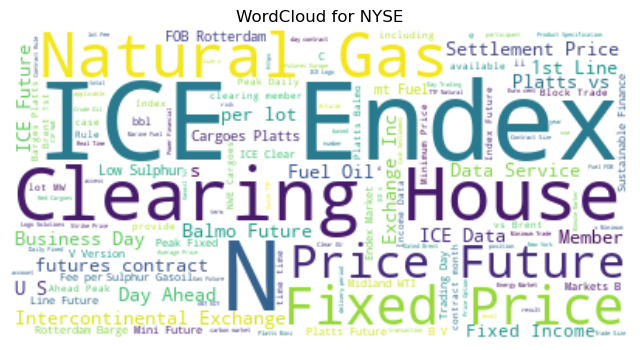

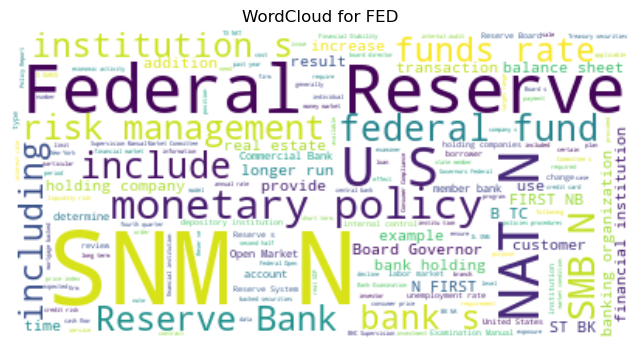

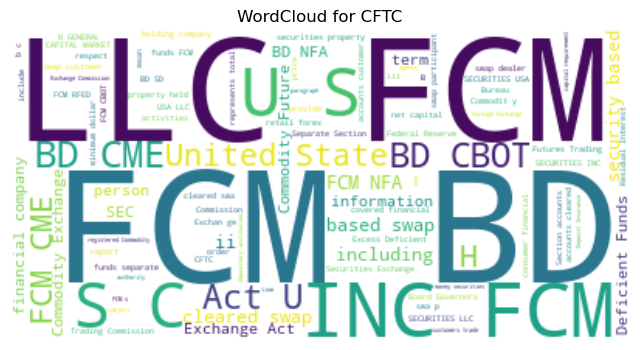

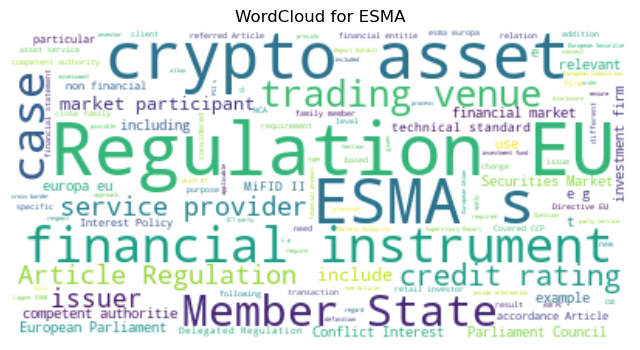

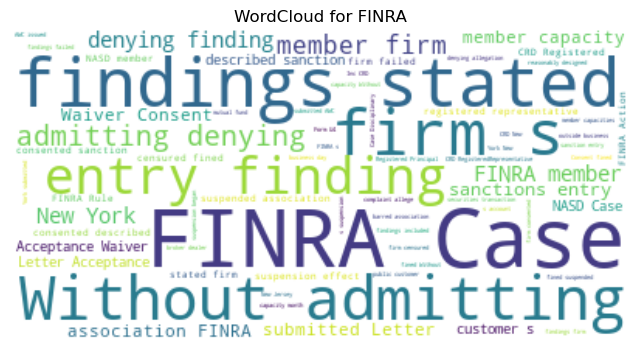

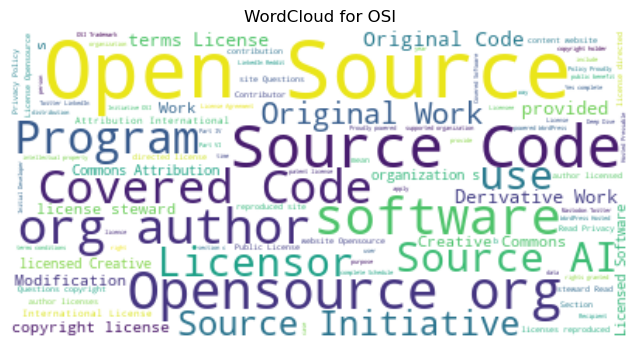

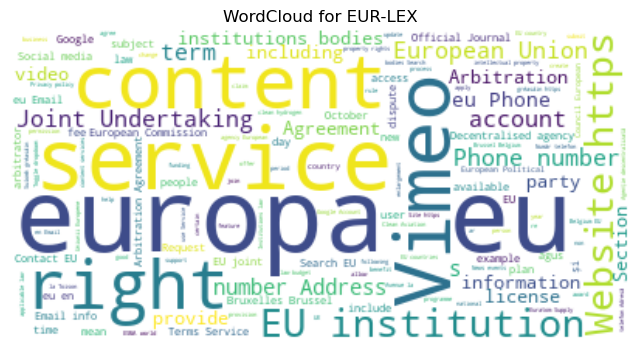

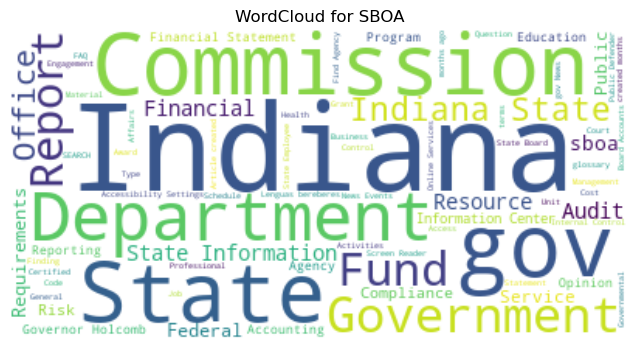

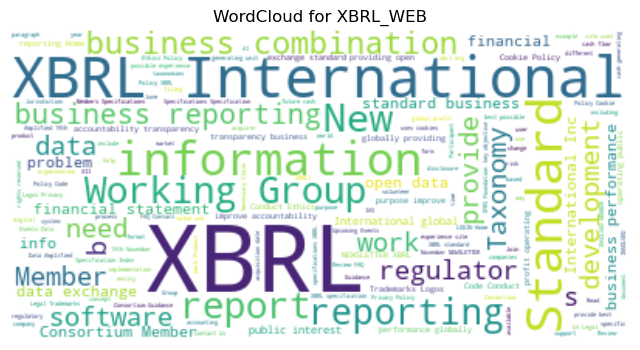

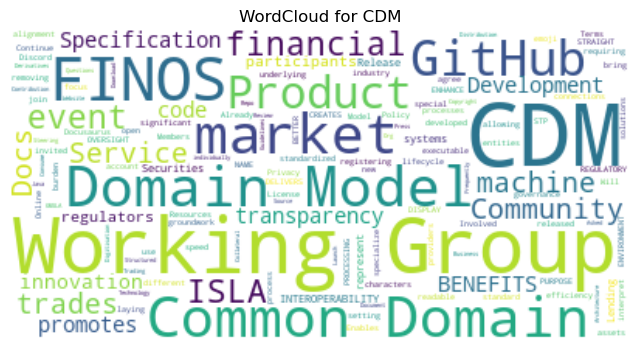

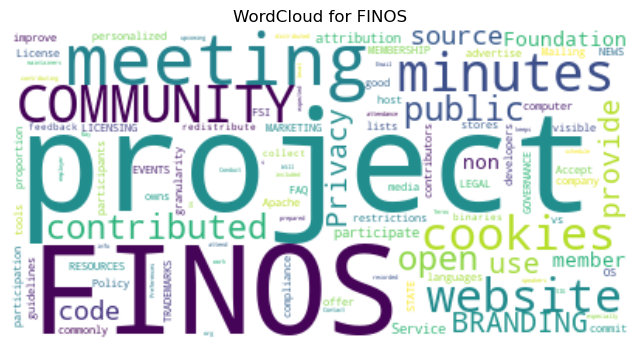

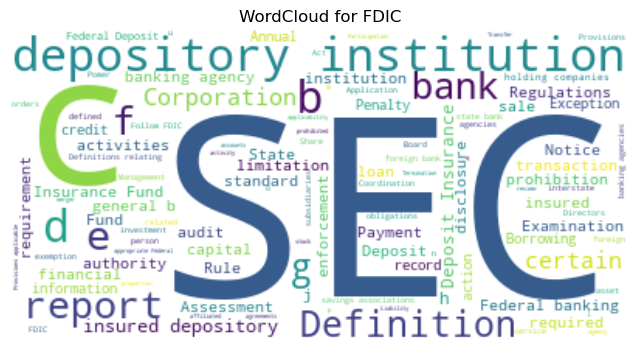

In [121]:
# Remove stopwords and generate word clouds for each source
for source in df_filtered['source'].unique():
    source_data = df_filtered[df_filtered['source'] == source]['content']  # Using original content
    generate_wordcloud(source_data, f'WordCloud for {source}')

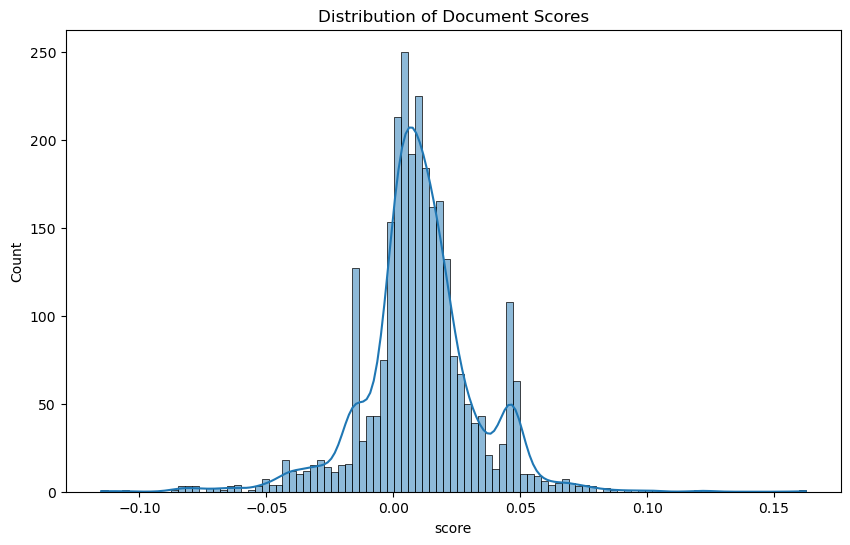

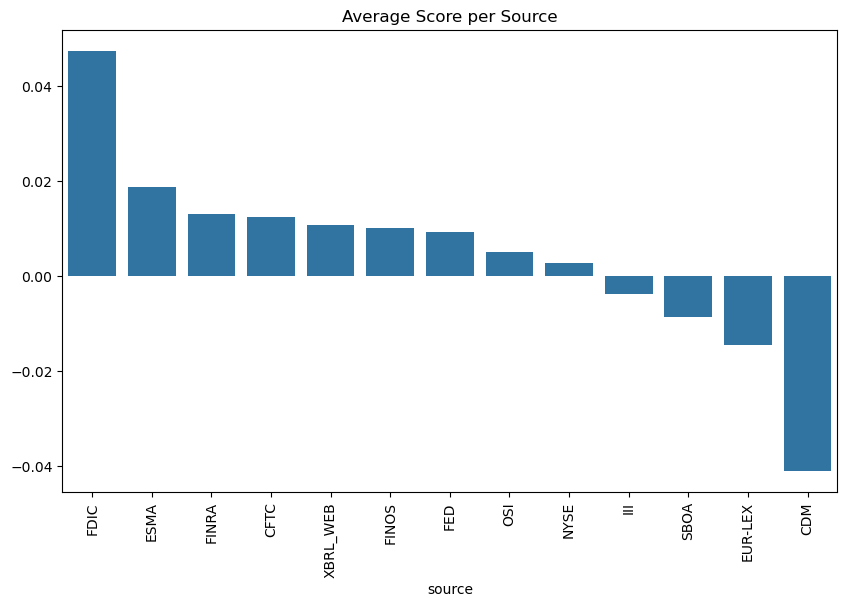

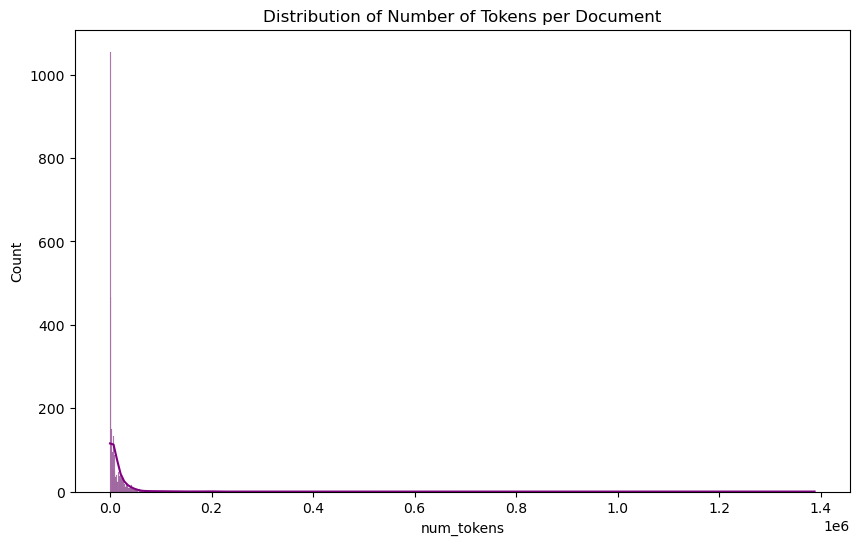

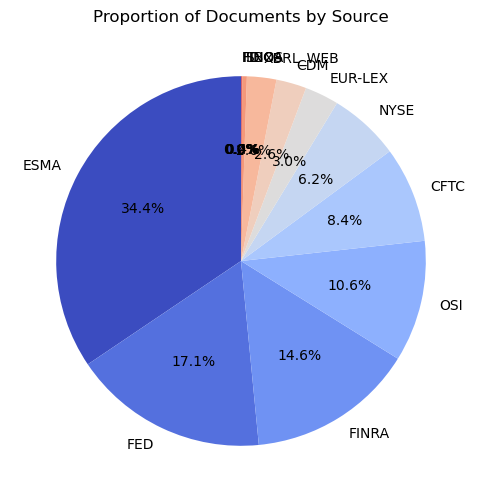

In [122]:
# Additional Visualizations

# 1. Distribution of Scores
plt.figure(figsize=(10,6))
sns.histplot(df['score'], kde=True)
plt.title('Distribution of Document Scores')
plt.show()

# 2. Average score per source
avg_score_per_source = df.groupby('source')['score'].mean().sort_values(ascending=False)
plt.figure(figsize=(10,6))
sns.barplot(x=avg_score_per_source.index, y=avg_score_per_source.values)
plt.xticks(rotation=90)
plt.title('Average Score per Source')
plt.show()

# 3. Number of tokens per document
plt.figure(figsize=(10,6))
sns.histplot(df['num_tokens'], kde=True, color='purple')
plt.title('Distribution of Number of Tokens per Document')
plt.show()

# 4. Proportion of documents per source
plt.figure(figsize=(10,6))
df['source'].value_counts().plot.pie(autopct='%1.1f%%', startangle=90, cmap='coolwarm')
plt.title('Proportion of Documents by Source')
plt.ylabel('')
plt.show()

C:\Users\santi\AppData\Local\Temp\ipykernel_4072\3791472293.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('Accent', len(sources))


Not enough data points for source 'III' (found 1)
1790   -0.003799
Name: score, dtype: float32
Not enough data points for source 'FDIC' (found 1)
1859    0.047336
Name: score, dtype: float32
Not enough data points for source 'FINOS' (found 1)
2374    0.009981
Name: score, dtype: float32


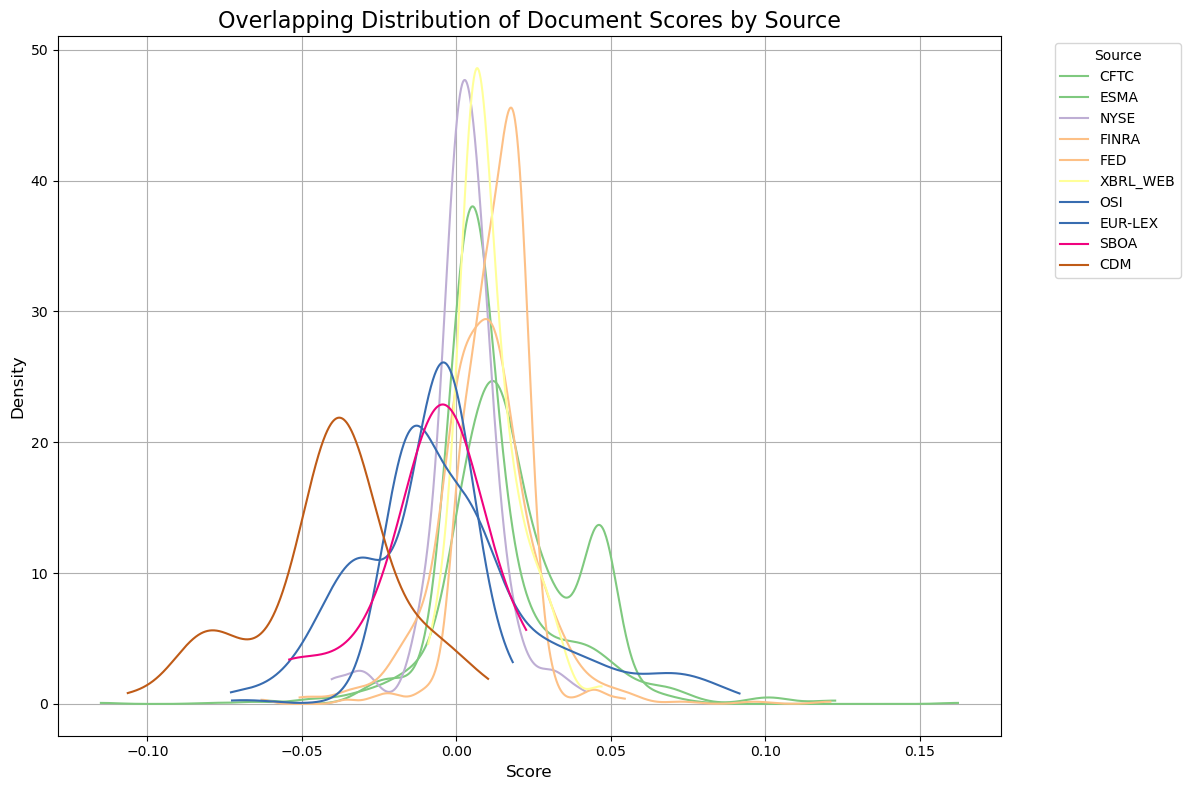

In [123]:
from scipy.stats import gaussian_kde

# Set up the figure size
plt.figure(figsize=(12, 8))

# Get the unique sources from the dataframe
sources = df['source'].unique()

# Define colors to use for each source
colors = plt.cm.get_cmap('Accent', len(sources))

# Plot KDE for each source
for i, source in enumerate(sources):
    # Filter data for the current source
    source_data = df[df['source'] == source]['score']
    
    # Check if the source_data has at least two points
    if len(source_data) > 1:
        # Compute KDE using gaussian_kde
        kde = gaussian_kde(source_data)
        x_vals = np.linspace(source_data.min(), source_data.max(), 1000)
        y_vals = kde(x_vals)
        
        # Plot the KDE curve for this source
        plt.plot(x_vals, y_vals, label=source, color=colors(i))
        
    else:
        print(f"Not enough data points for source '{source}' (found {len(source_data)})")
        print(source_data)

# Add title and labels
plt.title('Overlapping Distribution of Document Scores by Source', fontsize=16)
plt.xlabel('Score', fontsize=12)
plt.ylabel('Density', fontsize=12)

# Add a legend
plt.legend(title='Source', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)

# Show the plot with tight layout
plt.tight_layout()
plt.show()


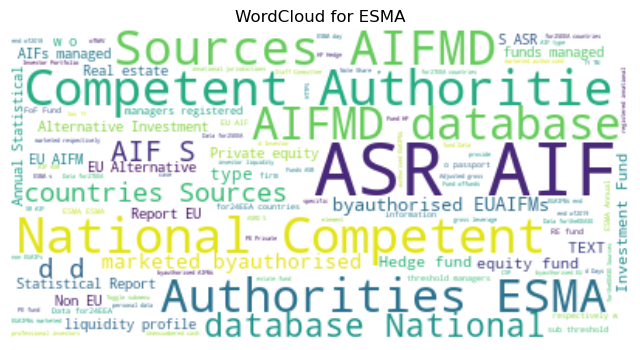

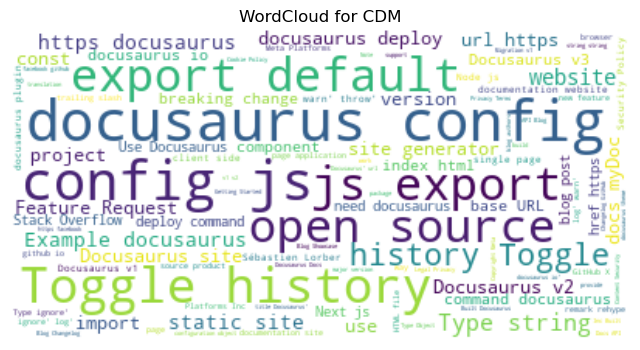

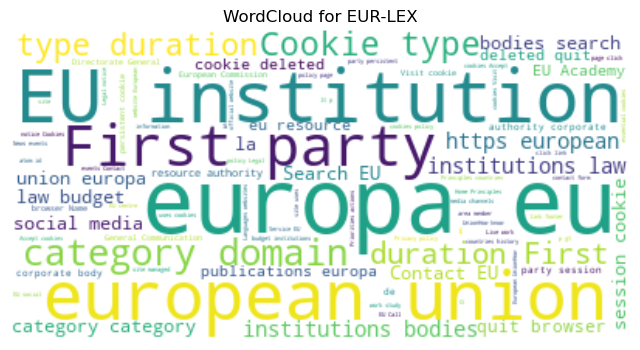

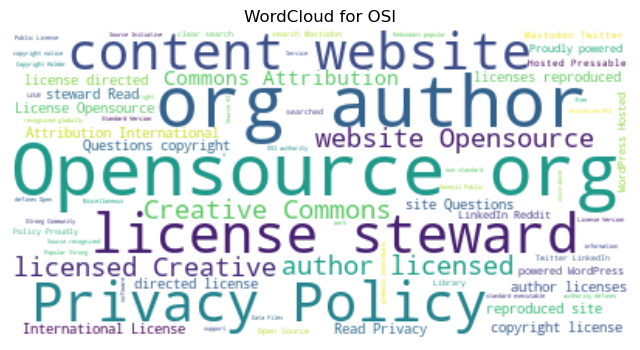

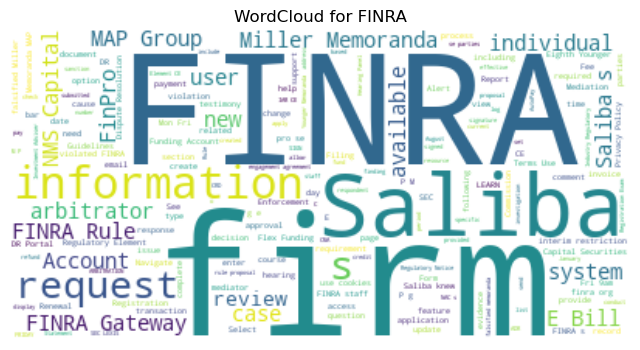

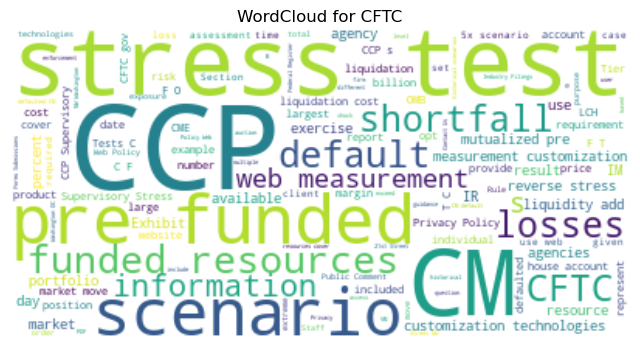

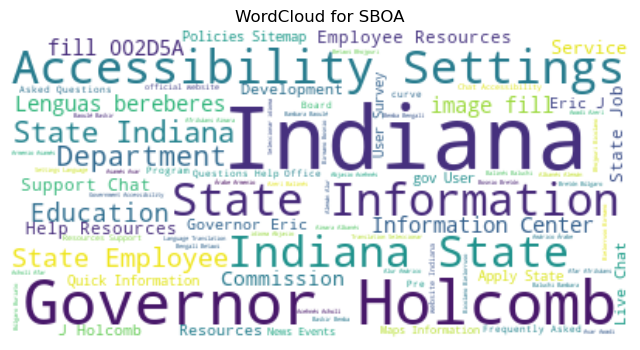

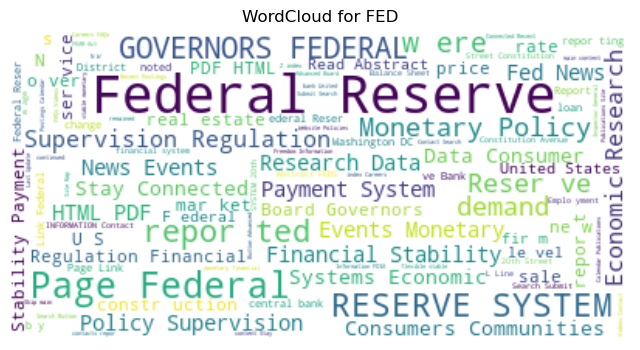

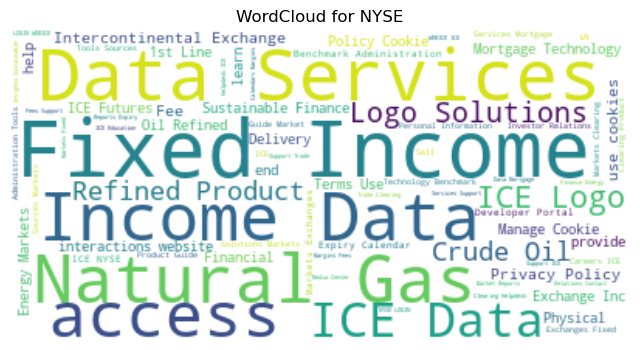

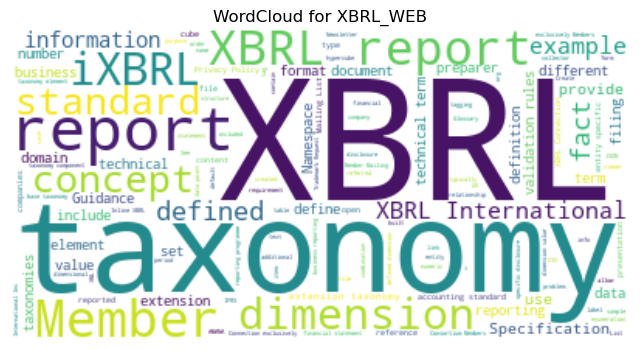

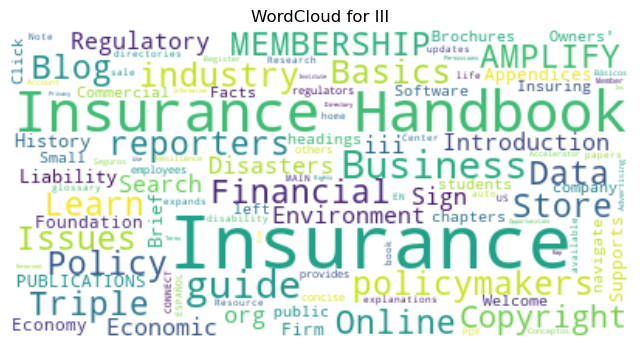

In [124]:
# Remove stopwords and generate word clouds for each source
for source in df_noisy['source'].unique():
    source_data = df_noisy[df_noisy['source'] == source]['content']  # Using original content
    generate_wordcloud(source_data, f'WordCloud for {source}')

In [125]:
df_filtered.to_csv("recursive_data/total/total_cleanedv2.csv",index=False)